diffusers library has a slight bug / oversight which makes fuse_qkv_projections() ignore certain attention modules. I updated the method to actually fuse for the desired attention modules, and this is the speedup comparisons after the fix.

In [1]:
%cd /home/ubuntu/Qwen-Image-Edit-Angles

/home/ubuntu/Qwen-Image-Edit-Angles


In [2]:
import math
from pathlib import Path
from collections import defaultdict
import statistics

import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import lpips
import torch
import torchvision.transforms.v2 as T
import torchvision.transforms.v2.functional as TF
from pydantic import BaseModel

from qwenimage.reporting.datamodels import ExperimentSet
from qwenimage.reporting.visualize_barplot import compare_sets, compare_sets_with_timing
from qwenimage.experiment import ExperimentConfig
from qwenimage.experiments.experiments_qwen import ExperimentRegistry

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipping import of cpp extensions due to incompatible torch version 2.9.1+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info
TMA benchmarks will be running without grid constant TMA descriptor.
2025-11-19 08:13:16.330127: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the envi

/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/ubuntu/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


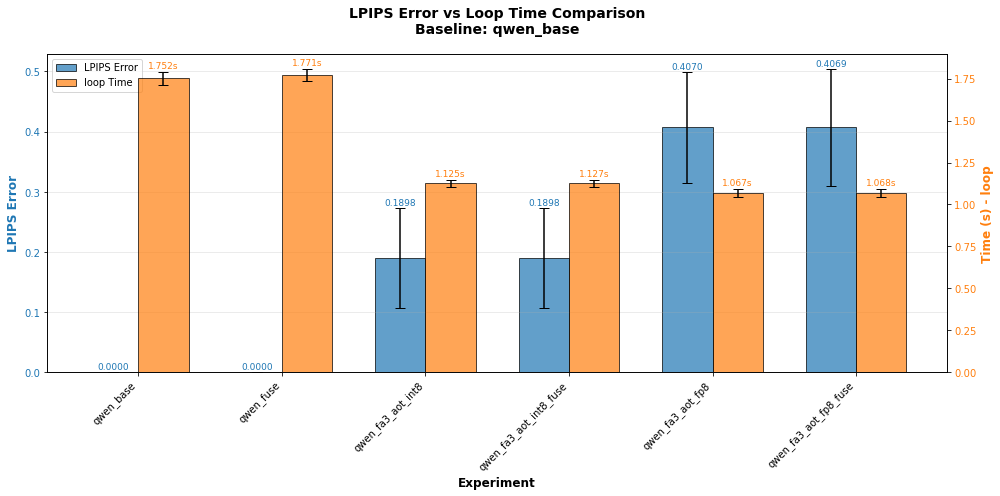

,experiment,lpips_mean,lpips_std,time_mean,time_std
0,qwen_base,0.000000,0.000000,1.752080,0.038048
1,qwen_fuse,0.000000,0.000000,1.771155,0.037701
2,qwen_fa3_aot_int8,0.189754,0.083396,1.125457,0.021317
3,qwen_fa3_aot_int8_fuse,0.189754,0.083396,1.126747,0.021306
4,qwen_fa3_aot_fp8,0.406982,0.092241,1.066962,0.023784
5,qwen_fa3_aot_fp8_fuse,0.406895,0.097481,1.067964,0.024570


In [3]:


experiment_names = [
    "qwen_base",
    "qwen_fuse",
    # "qwen_fa3",
    # "qwen_aot", 
    # "qwen_fa3_aot", 

    # "qwen_fa3_fuse",
    # "qwen_fuse_aot",

    "qwen_fa3_aot_int8",
    "qwen_fa3_aot_int8_fuse",

    "qwen_fa3_aot_fp8",
    "qwen_fa3_aot_fp8_fuse",

    # "qwen_lightning_fa3_aot_int8_fuse_4step_fbcache_055_downsize512",
]

df_all = compare_sets_with_timing(
    ExperimentSet.create(*experiment_names),
    profile_target="loop",
    sort_by=None
)

# Display the combined data
df_all


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ubuntu/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


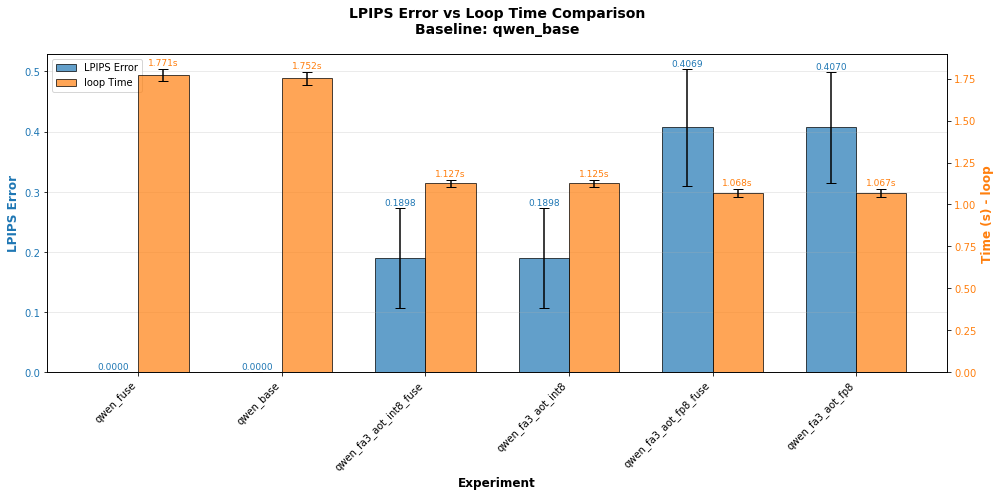

,experiment,lpips_mean,lpips_std,time_mean,time_std
1,qwen_fuse,0.000000,0.000000,1.771155,0.037701
0,qwen_base,0.000000,0.000000,1.752080,0.038048
3,qwen_fa3_aot_int8_fuse,0.189754,0.083396,1.126747,0.021306
2,qwen_fa3_aot_int8,0.189754,0.083396,1.125457,0.021317
5,qwen_fa3_aot_fp8_fuse,0.406895,0.097481,1.067964,0.024570
4,qwen_fa3_aot_fp8,0.406982,0.092241,1.066962,0.023784


In [4]:

compare_sets_with_timing(
    ExperimentSet.create(
       *experiment_names
    ),
    profile_target="loop",
    sort_by="time"
)
